In [1]:
# !pip install lightkurve==1.4.0

import lightkurve as lk
lk.__version__

'1.4.0'

In [2]:
# crea graficos interactivos
%matplotlib inline
from astropy.io import fits #para acceder a los archivos FITS
from astropy.table import Table # para crear tablas ordenadas de los datos
import matplotlib.pyplot as plt # para plotear datos
import pandas as pd
import numpy as np
import glob
import math
import os
import random as rnd

# mostrar max columnas necesarias
pd.set_option('display.max_columns', 500) 

In [3]:
from astroquery.mast import Mast
from astroquery.mast import Observations

In [7]:
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)

df_koi = df_koi[df_koi["kepid"] == 11446443]

[ 0 / 1 ] descargando fits de KIC 11446443  -  Kepler-1 b
-> FLUX global (3997,)
-> FLUX local (941,)


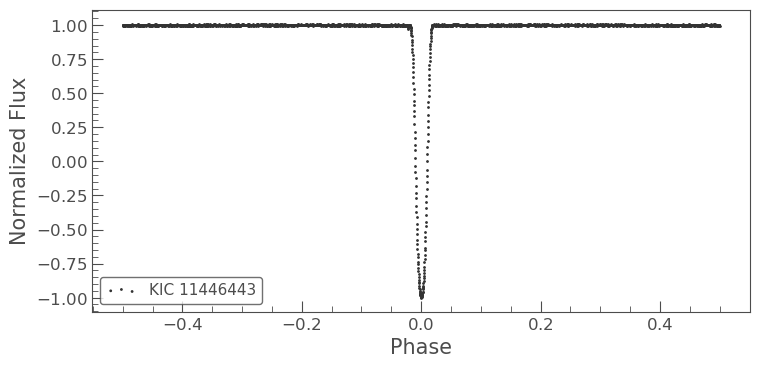

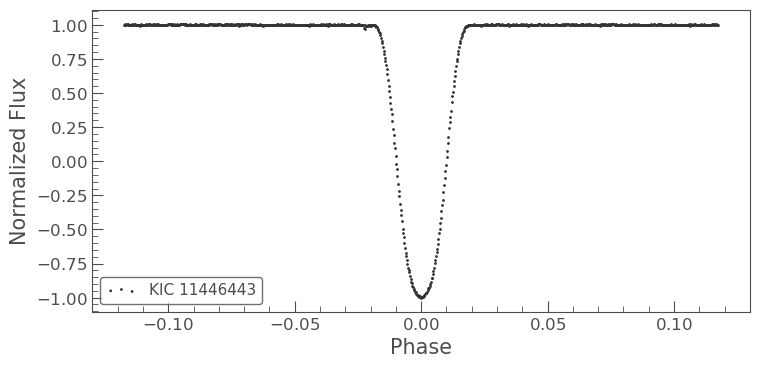

In [10]:
len_df_koi = len(df_koi)
for i in range(0, len_df_koi):
    row = df_koi.iloc[i]
    period, t0, duration_hours = row['koi_period'], row['koi_time0bk'], row['koi_duration']
    
    kepoi_folder = "./lightkurve/" + row["kepoi_name"]
    kepoi_file_global = kepoi_folder + "/" + row["kepoi_name"] + "_global.csv"
    kepoi_file_local = kepoi_folder + "/" + row["kepoi_name"] + "_local.csv"
    if not os.path.exists(kepoi_folder):
        os.makedirs(kepoi_folder)

    try:

        kic = "KIC " + str(row['kepid'])
        print("[",i,"/", len_df_koi,"] descargando fits de", kic, " - ", row['kepler_name'])
        lcfs = lk.search_lightcurvefile(kic, mission='Kepler').download_all()

        lc_raw = lcfs.PDCSAP_FLUX.stitch()
        lc_raw.flux.shape

        lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4)

        temp_fold = lc_clean.fold(period, t0=t0)
        fractional_duration = (duration_hours / 24.0) / period
        phase_mask = np.abs(temp_fold.phase) < (fractional_duration * 1.5)
        transit_mask = np.in1d(lc_clean.time, temp_fold.time_original[phase_mask])

        lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)

        lc_fold = lc_flat.fold(period, t0=t0)

        lc_global = lc_fold.bin(method='median').normalize() - 1
        lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
        print("-> FLUX global", lc_global.flux.shape)

        lc_global.scatter();

        #

        phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
        lc_zoom = lc_fold[phase_mask]

        lc_local = lc_zoom.bin(method='median').normalize() -1
        lc_local = (lc_local / np.abs(lc_local.flux.min()) ) * 2.0 + 1
        print("-> FLUX local", lc_local.flux.shape)

        lc_local.scatter();

    except:
        print("ERROR")
